# Analyses of adversarial scenarios

In [1]:
require(data.table)
require(ggplot2)
require(lubridate)
require(magrittr)

Loading required package: data.table

Loading required package: ggplot2

Loading required package: lubridate

Loading required package: timechange


Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: magrittr



## No honest quorum in round

In [2]:
prob <- function(f, C)
  pnorm(f, 1 / 4, sqrt((1 - f) / C))

In [3]:
result <-
  CJ(f=0:250/1000, C=1:100*10)[,
    .(f, C, P=prob(f, C))
  ]

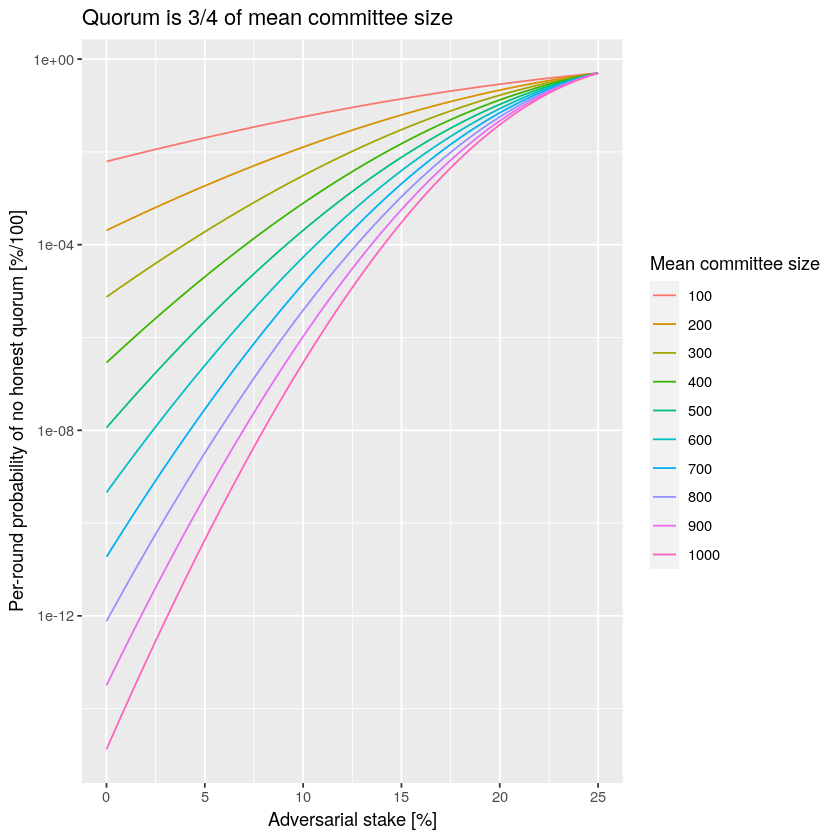

In [4]:
ggplot(result[`C` %in% (1:10*100)], aes(x=100*f, y=P, color=factor(C))) +
  geom_line() +
  scale_y_log10() +
  xlab("Adversarial stake [%]") +
  ylab("Per-round probability of no honest quorum [%/100]") +
  guides(color=guide_legend(title="Mean committee size")) +
  ggtitle("Quorum is 3/4 of mean committee size")

In [5]:
ggsave(file="no-honest-quorum.plot.png", width=6, height=4, units="in", dpi=150)

In [6]:
ggsave(file="no-honest-quorum.plot.svg", width=6, height=4, units="in", dpi=150)

## Adversarial chain receives boost

In [7]:
prob <- function (U, p, q) {
  f <- q / (p + q)
  p0 <- (1 - f) * sum( pbinom(0:(U-1), U, p) * dbinom(1:U, U, q) )
  pk <- (1 - f) * sum( mapply(function(k) f^k * sum( pbinom((k-1):(U-1), U, p) * dbinom(0:(U-k), U, q) ), 1:U) )
  pinf <- f^(U+1)
  p0 + pk + pinf
}

In [8]:
result <-
  CJ(alpha=0.05, U=seq(30, 1200, 10), f=seq(0, 0.5, 0.005))[,
    .(alpha, U, f, p=alpha*(1-f), q=alpha*f)
  ][, 
    .(alpha, U, f, p, q, P=mapply(prob,U,p,q))
  ]

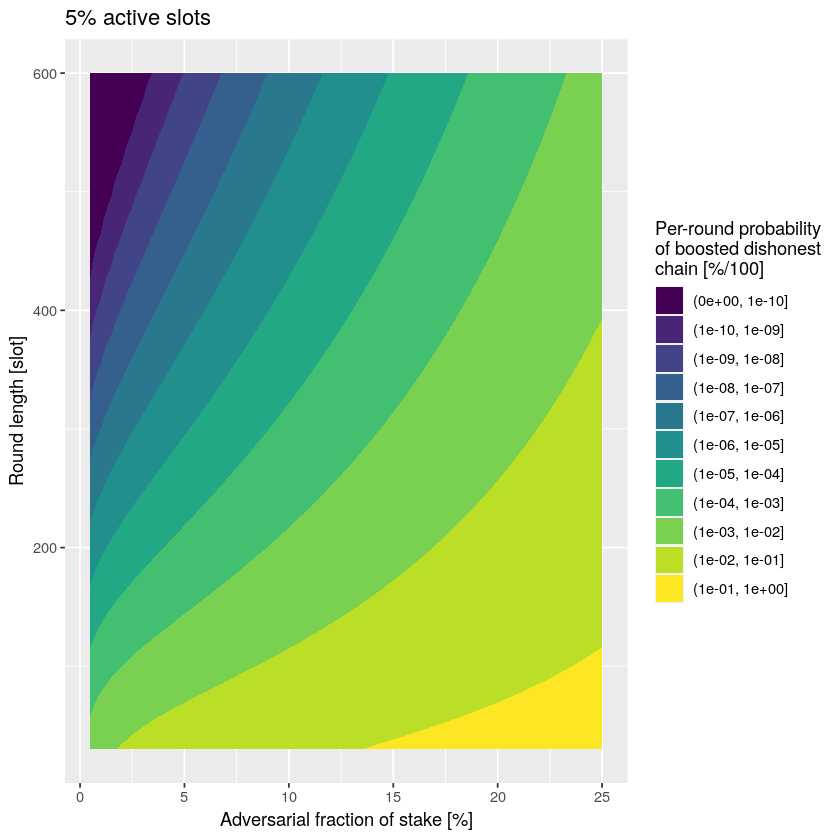

In [9]:
ggplot(result[P > 0 & f <= 0.25 & U <= 600], aes(x=100*f, y=U, z=P)) +
  geom_contour_filled(breaks=c(0,10^(-(10:0)))) +
  xlab("Adversarial fraction of stake [%]") +
  ylab("Round length [slot]") +
  ggtitle(paste(100 * unique(result$alpha), "% active slots", sep="")) +
  guides(fill=guide_legend(title="Per-round probability\nof boosted dishonest\nchain [%/100]"))

In [10]:
ggsave(file="adversarial-chain-receives-boost-variant.plot.svg", width=6, height=4, units="in", dpi=150)

In [11]:
ggsave(file="adversarial-chain-receives-boost-variant.plot.png", width=6, height=4, units="in", dpi=150)

## Markov-chain simulation

In [12]:
mcresult <- fread("results-1200.tsv")

In [13]:
mcresult %>% summary

   Protcol            Threshold     Adversary           Slot       
 Length:480000      Min.   :  0   Min.   :0.0000   Min.   :   1.0  
 Class :character   1st Qu.:  0   1st Qu.:0.1237   1st Qu.: 300.8  
 Mode  :character   Median : 60   Median :0.2475   Median : 600.5  
                    Mean   : 60   Mean   :0.2475   Mean   : 600.5  
                    3rd Qu.:120   3rd Qu.:0.3713   3rd Qu.: 900.2  
                    Max.   :120   Max.   :0.4950   Max.   :1200.0  
  Probability    
 Min.   :0.0000  
 1st Qu.:0.0200  
 Median :0.1485  
 Mean   :0.2304  
 3rd Qu.:0.3869  
 Max.   :0.8872  

In [14]:
colnames(mcresult) <- c("Protocol", "Threshold", "Adversarial", "Final", "Probability")

In [15]:
mcresult[Threshold == 0, Scenario:=factor("Ex Ante:\nblock is on honest\nchain initially\n ")]

In [16]:
mcresult[Threshold == 120, Scenario:=factor("Post facto:\nblock is still on\nhonest chain\nafter 120 slots\n ")]

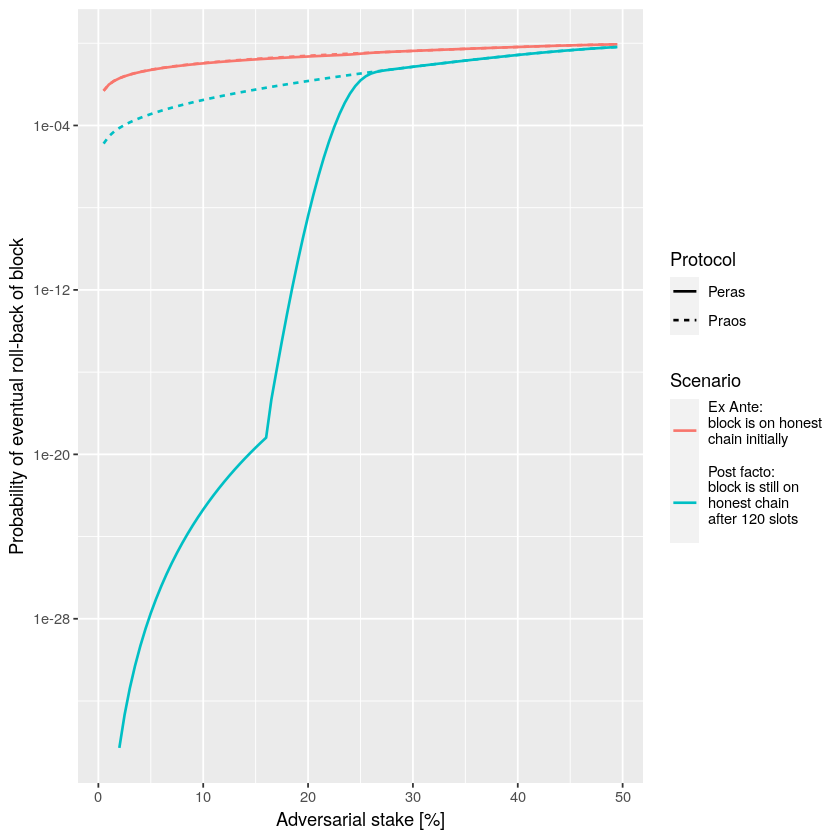

In [17]:
ggplot(
    mcresult[Final == max(mcresult$Final) & Threshold %in% c(0, 120) & Probability > 0],
    aes(x=100*Adversarial, y=Probability, color=Scenario, linetype=Protocol)
) +
    geom_line(linewidth=0.75) +
    scale_y_log10() +
    xlab("Adversarial stake [%]") +
    ylab("Probability of eventual roll-back of block")

In [18]:
ggsave(file="rollback-posterior.svg", width=8, height=6, units="in", dpi=150)

In [19]:
ggsave(file="rollback-posterior.png", width=8, height=6, units="in", dpi=150)

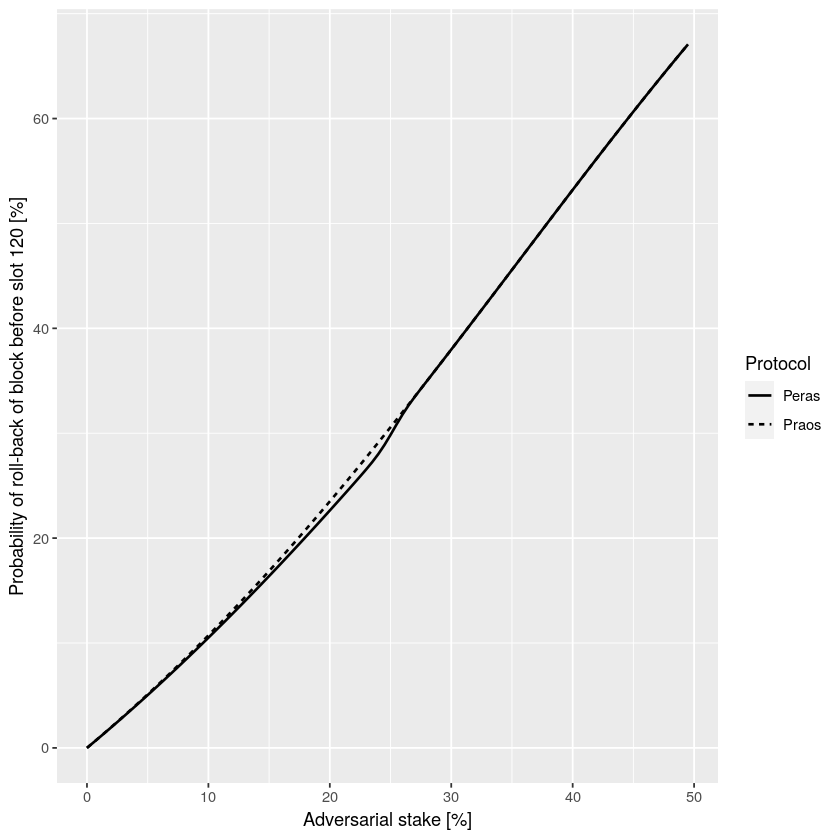

In [20]:
ggplot(
    mcresult[Threshold %in% c(0, 120) & Final < 120, .(Probability=max(Probability)), by=.(Adversarial, Protocol, Scenario)],
    aes(x=100*Adversarial, y=100*Probability, linetype=Protocol)
) +
    geom_line(linewidth=0.75) +
    xlab("Adversarial stake [%]") +
    ylab("Probability of roll-back of block before slot 120 [%]")

In [21]:
ggsave(file="rollback-prior.svg", width=8, height=6, units="in", dpi=150)

In [22]:
ggsave(file="rollback-prior.png", width=8, height=6, units="in", dpi=150)

## Node average traffic

In [23]:
hor <- matrix(c(149.1491,474.82261 , 516.46512,-0.58175), ncol=2, byrow=TRUE)
hor

149.1491,474.82261
516.4651,-0.58175


In [24]:
ver <- matrix(c(149.7507,474.54125 , 149.41083,124.70846), ncol=2, byrow=TRUE)
ver[2,1] <- ver[2,1] - ver[1,1]
ver[2,2] <- ver[2,2] - ver[1,2]
ver

149.75070,474.5412
-0.33987,-349.8328


In [25]:
fx <- matrix(c(459.14554,346.13071 , 4.36822,-112.41406 , 6.04145,33.58117 , 3.96905,42.2540), ncol=2, byrow=TRUE)
colnames(fx) <- c("X", "Y")
fx <- data.table(fx)
fx

X,Y
<dbl>,<dbl>
459.14554,346.13071
4.36822,-112.41406
6.04145,33.58117
3.96905,42.25400


In [26]:
dp <- matrix(c(86.215971,324.98924 , 4.623904,-90.67002 , 4.548034,78.61369 , 5.565601,20.80126 , 4.98797,-48.56496 , 4.44849,73.76952 , 5.06037,-52.3938 , 4.67803,-22.40475 , 9.65515,81.55491 , 5.12375,-44.12558 , 9.52631,-29.03748 , 5.03728,-61.19679 , 5.02912,97.14845 , 4.37905,3.05976 , 6.28808,-13.71117 , 3.72825,-44.12275 , 4.86118,-4.05527 , 4.96606,-21.94474 , 6.4795,-3.33904 , 4.28474,84.46138 , 5.00999,-26.75927 , 4.65514,-51.99451 , 4.42944,18.25088 , 5.24536,-8.85807 , 5.39626,60.16933 , 3.85069,-69.64434 , 5.42124,57.3135 , 5.19675,-56.47994 , 4.48151,40.62963 , 10.12407,-66.38753 , 4.87415,19.72593 , 4.34235,-185.640856 , 5.21293,145.359706 , 10.05005,90.0648 , 4.58577,-35.89422 , 5.32958,17.5784 , 4.75762,-4.10462 , 4.59171,-52.41654 , 5.19335,136.09503 , 4.34257,-138.94594 , 5.48284,62.76919 , 9.59642,-91.85567 , 4.66732,29.57026 , 5.42259,10.00286 , 4.35131,122.18051 , 4.63229,-160.41045 , 5.60935,-54.88605 , 4.46827,184.9599 , 4.92988,22.08065 , 4.85076,-123.83641 , 4.78914,59.31542 , 5.39205,-8.86465 , 4.8918,66.70222 , 5.16648,-74.113 , 4.78966,3.69366 , 4.55031,-7.19757 , 5.92917,-12.65481 , 4.10533,-43.15479 , 4.97195,59.88516 , 5.11424,25.83824 , 9.46307,-49.04655 , 5.07158,-58.48988 , 5.07078,42.76583 , 5.20323,-3.67289 , 4.38773,62.89243 , 5.06098,35.61773 , 5.4127,-30.15121 , 4.78445,10.36162 , 4.18441,-68.29871 , 9.5035,116.89299 , 4.58863,-113.26688 , 10.13463,76.49459 , 5.04386,-56.60853 , 5.25158,-19.63422 , 5.60074,105.58633 , 3.97992,-73.41685 , 5.18795,-16.5626 , 4.40072,-84.76768 , 5.07536,148.61088 , 4.70022,-69.70295 , 5.4839,90.59506 , 4.90111,-53.32622 , 4.46001,16.28631 , 5.21881,0.93583 , 5.16651,113.98542 , 5.88806,-113.27571 , 3.53032,-127.91604 , 5.3571,130.81913 , 4.47147,-47.42522 , 4.22697,12.6269 , 4.82386,36.7813 , 5.5647,28.75442 , 5.91894,-12.54202 , 5.04206,-133.70738 , 4.36194,41.41285 , 4.99585,72.9581 , 9.09951,-64.14235 , 5.15307,15.41316 , 5.28996,-136.28918 , 9.99922,191.79864 , 4.36607,-75.86456 , 4.66207,7.49637 , 5.4789,-26.09218 , 4.56827,21.6146 , 5.04943,-30.85381 , 5.21648,60.34827 , 4.44095,-64.00112 , 10.00556,85.29349 , 5.64168,18.49905), ncol=2, byrow=TRUE)
colnames(dp) <- c("X", "Y")
dp <- data.table(dp)
dp[, `:=`(P="In", X=(cumsum(X) - hor[1,1]) / hor[1,2] * 105, Y=(cumsum(Y) - ver[1,2]) / ver[2,2] * 1.5)]
dp %>% head

X,Y,P
<dbl>,<dbl>,<chr>
-13.916731,0.6412435,In
-12.894223,1.0300151,In
-11.888493,0.6929382,In
-10.657742,0.6037474,In
-9.554726,0.8119824,In
-8.571009,0.4956762,In


In [27]:
dm <- matrix(c(84.881671,543.92955 , 6.116459,56.75092 , 4.372453,-58.57302 , 4.362684,-7.07984 , 5.958623,47.56121 , 4.69844,285.77603 , 5.05826,-288.44468 , 4.39261,1.41403 , 4.79754,-44.54391 , 5.21778,-14.85283 , 5.27286,45.39421 , 4.51942,-22.33997 , 5.10237,32.94296 , 4.9983,11.26866 , 4.28143,-53.63861 , 5.08672,2.50231 , 4.90232,12.98027 , 4.43332,4.84427 , 4.78798,1.87736 , 5.1881,25.00909 , 5.6574,15.76009 , 5.32608,-64.32189 , 5.14786,12.16735 , 4.61361,26.85298 , 5.31183,-2.58091 , 4.5898,-12.54925 , 4.74836,68.15555 , 4.2952,-78.69113 , 5.38793,-10.20963 , 4.94112,62.74973 , 4.30427,-32.23333 , 5.83706,22.38487 , 5.67058,0.78238 , 3.56663,-6.67761 , 5.4094,149.87022 , 4.18994,-170.35149 , 5.68198,278.70415 , 4.30895,-299.27601 , 5.19762,23.66612 , 4.72654,-17.43863 , 4.6804,-3.6195 , 5.30509,50.26697 , 5.1803,-74.46226 , 4.60227,51.91025 , 4.46578,-26.78389 , 5.48324,61.90785 , 5.13738,-8.62969 , 3.63557,-28.74864 , 5.63535,-4.23111 , 4.95179,-29.17978 , 4.85953,86.60338 , 4.74352,16.61858 , 4.68651,-79.96847 , 4.73045,-28.8894 , 5.53077,60.49977 , 4.58674,-45.47111 , 5.28756,6.29906 , 4.11958,16.95604 , 5.52286,-0.51901 , 4.03841,15.38983 , 5.97236,-27.6419 , 4.99053,-4.98069 , 5.09795,48.55557 , 4.77853,-42.3377 , 4.86613,-17.18561 , 4.81907,20.99369 , 5.1746,39.38481 , 9.71999,-29.22611 , 4.48912,0.19656 , 5.16583,-32.33904 , 4.87825,3.24757 , 5.2754,13.17739 , 4.58872,-5.27077 , 4.98956,16.69796 , 4.76395,-14.57283 , 4.07004,-34.23877 , 5.74739,55.29811 , 4.49874,3.77607 , 5.40295,-45.11208 , 9.43056,56.29412 , 5.13662,-39.17421 , 4.96242,-3.27654 , 4.50458,29.52763 , 5.55477,55.46697 , 3.98149,-80.47625 , 5.54066,45.31579 , 4.73447,-76.19474 , 5.30524,39.80105 , 9.81028,-17.70494 , 3.90527,-43.4409 , 10.1025,84.30594 , 4.85182,-39.05051 , 5.68474,34.46601 , 4.77101,-15.00493 , 5.56447,8.50995 , 3.60649,-20.13492 , 5.65576,10.19132 , 5.18974,17.23832 , 4.4382,-28.83859 , 4.90256,20.21619 , 5.66919,-17.77978 , 3.33301,5.90134 , 5.84981,-0.84251 , 4.95403,31.63873 , 5.18133,-34.45902 , 4.43201,-17.32788 , 5.18718,28.36409 , 4.64112,5.5699 , 5.02687,26.49734 , 4.86705,-41.23826 , 5.00188,22.73869 , 5.09441,-29.74743 , 4.97173,55.15423 , 3.77907,-5.4382 , 5.55989,-3.76974 , 5.64492,5.37296), ncol=2, byrow=TRUE)
colnames(dm) <- c("X", "Y")
dm <- data.table(dm)
dm[, `:=`(P="Out", X=(cumsum(X) - hor[1,1]) / hor[1,2] * 105, Y=- (cumsum(Y) - ver[1,2]) / ver[2,2] * 1.5)]
dm %>% head

X,Y,P
<dbl>,<dbl>,<chr>
-14.211792,0.2975206,Out
-12.859227,0.5408550,Out
-11.892324,0.2897078,Out
-10.927581,0.2593512,Out
-9.609919,0.4632823,Out
-8.570929,1.6886222,Out


In [28]:
traffic <- rbind(dp, dm)[, .(
    `Direction`=P,
    `Timestamp`=as_datetime(1719402600 + 60 * X),
    `Traffic [kb/s]`=1000*Y
)]
traffic %>% head

Direction,Timestamp,Traffic [kb/s]
<chr>,<dttm>,<dbl>
In,2024-06-26 11:36:04,641.2435
In,2024-06-26 11:37:06,1030.0151
In,2024-06-26 11:38:06,692.9382
In,2024-06-26 11:39:20,603.7474
In,2024-06-26 11:40:26,811.9824
In,2024-06-26 11:41:25,495.6762


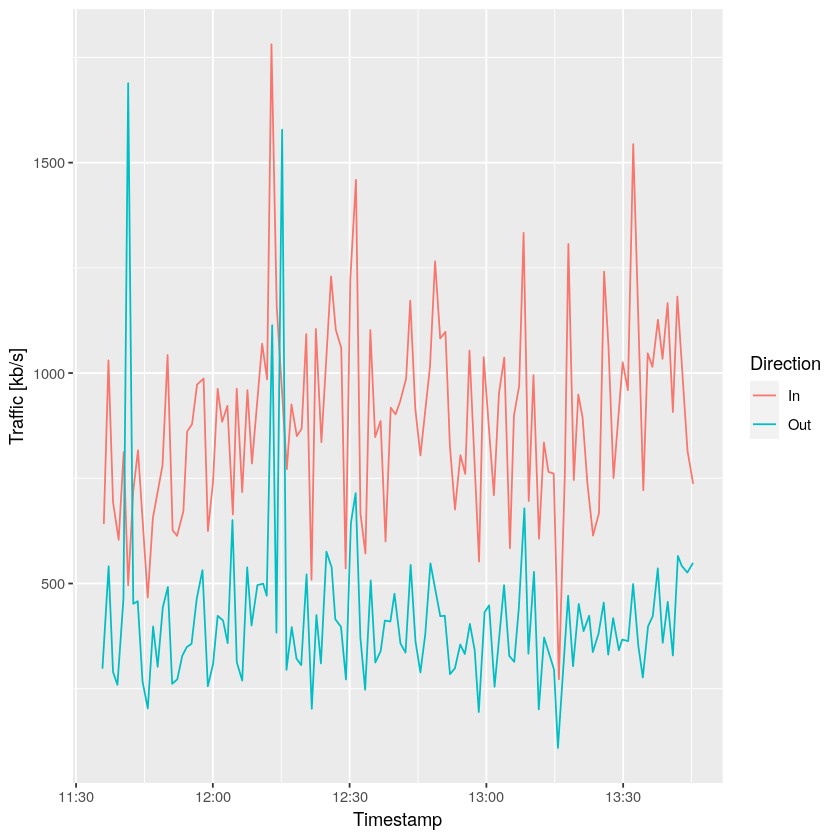

In [29]:
ggplot(traffic, aes(x=`Timestamp`, y=`Traffic [kb/s]`, color=`Direction`)) +
  geom_line()

In [30]:
ggsave(file="node-average-traffic.png", width=8, height=6, units="in", dpi=150)

In [31]:
ggsave(file="node-average-traffic.svg", width=8, height=6, units="in", dpi=150)